In [1]:
import pandas as pd

# Cargar el archivo CSV
patch='/content/drive/MyDrive/0002 Python - Data Science/Datasets/insurance.csv'
df = pd.read_csv(patch)


In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Información general
df.info()

# Tipos de datos únicos por columna
df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,0
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


In [ ]:
# Conteo de valores nulos
df.isnull().sum()


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
# Estadísticas numéricas
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Outliers por IQR
numerical_cols = ['age', 'bmi', 'children', 'charges']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f'{col}: {len(outliers)} outliers')


age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


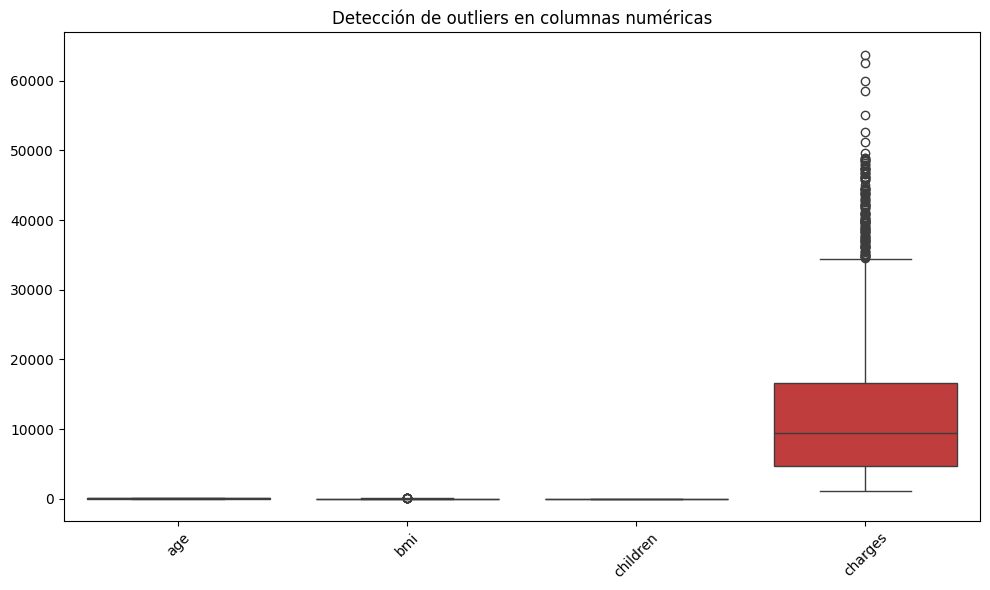

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.select_dtypes(include=np.number))
plt.title("Detección de outliers en columnas numéricas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## La variable charges presenta una alta dispersión y una gran cantidad de valores atípicos, lo cual es esperable debido a la naturaleza del gasto médico. Aunque estos valores son extremos, podrían representar situaciones clínicas válidas y no necesariamente errores, por lo que deben tratarse con cuidado y no eliminarse automáticamente.

In [5]:
# Detección de outliers usando IQR
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]
    return outliers

# Revisar cada columna numérica
columnas_numericas = df.select_dtypes(include=np.number).columns
outliers_dict = {}

for col in columnas_numericas:
    outliers = detectar_outliers_iqr(df, col)
    outliers_dict[col] = len(outliers)

# Mostrar resumen
print("Cantidad de outliers detectados por columna:")
for col, count in outliers_dict.items():
    print(f"{col}: {count} outliers")


Cantidad de outliers detectados por columna:
age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


Usando el método del Rango Intercuartílico (IQR), se identificaron outliers en dos variables:

bmi: 9 valores atípicos, que podrían representar casos de obesidad fuera de lo habitual.

charges: 139 outliers, lo cual es consistente con lo observado en el boxplot. Estos valores extremos probablemente reflejan tratamientos médicos costosos o condiciones graves.

No se detectaron outliers en age ni en children, lo que sugiere que sus distribuciones son más homogéneas.

⚠️ Dado que los outliers en charges podrían tener valor informativo importante, se recomienda no eliminarlos automáticamente sino considerar su impacto durante el modelado (por ejemplo, usando modelos robustos o transformación logarítmica).

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separar X e y
X = df.drop('charges', axis=1)
y = (df['charges'] > df['charges'].median()).astype(int)

In [8]:
# Identificar columnas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [9]:
# Transformador para variables numéricas
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),     # Imputación por mediana (aunque no hay nulos)
    ('scaler', StandardScaler())                       # Escalado
])

# Transformador para variables categóricas
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación por moda
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))  # Codificación OHE
])

In [10]:
# Preprocesador general
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Lista de modelos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42)
}

# Evaluación con validación cruzada
for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[('preprocesamiento', preprocessor),
                                ('modelo', modelo)])

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

    print(f"\n{nombre}")
    print(f"Accuracy (media ± std): {scores.mean():.4f} ± {scores.std():.4f}")





Regresión Logística
Accuracy (media ± std): 0.9073 ± 0.0270

K-Nearest Neighbors
Accuracy (media ± std): 0.8886 ± 0.0316

Árbol de Decisión
Accuracy (media ± std): 0.8842 ± 0.0227


In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint

# --- Regresión Logística con GridSearchCV ---
pipe_lr = Pipeline(steps=[
    ('preprocesamiento', preprocessor),
    ('modelo', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_lr = {
    'modelo__C': [0.01, 0.1, 1, 10],
    'modelo__penalty': ['l2'],
    'modelo__solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X, y)

print("Mejor resultado - Regresión Logística (GridSearchCV):")
print(f"Accuracy: {grid_lr.best_score_:.4f}")
print("Mejores hiperparámetros:", grid_lr.best_params_)

Mejor resultado - Regresión Logística (GridSearchCV):
Accuracy: 0.9111
Mejores hiperparámetros: {'modelo__C': 10, 'modelo__penalty': 'l2', 'modelo__solver': 'lbfgs'}


In [16]:
# --- Árbol de Decisión con RandomizedSearchCV ---
pipe_dt = Pipeline(steps=[
    ('preprocesamiento', preprocessor),
    ('modelo', DecisionTreeClassifier(random_state=42))
])

param_dist_dt = {
    'modelo__max_depth': randint(3, 20),
    'modelo__min_samples_split': randint(2, 10),
    'modelo__min_samples_leaf': randint(1, 10)
}

rand_dt = RandomizedSearchCV(pipe_dt, param_distributions=param_dist_dt,
                             n_iter=20, cv=5, scoring='accuracy', random_state=42)
rand_dt.fit(X, y)

print("\n Mejor resultado - Árbol de Decisión (RandomizedSearchCV):")
print(f"Accuracy: {rand_dt.best_score_:.4f}")
print("Mejores hiperparámetros:", rand_dt.best_params_)


 Mejor resultado - Árbol de Decisión (RandomizedSearchCV):
Accuracy: 0.9230
Mejores hiperparámetros: {'modelo__max_depth': 5, 'modelo__min_samples_leaf': 5, 'modelo__min_samples_split': 4}


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Separar train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar los modelos óptimos
best_lr = grid_lr.best_estimator_
best_dt = rand_dt.best_estimator_

best_lr.fit(X_train, y_train)
best_dt.fit(X_train, y_train)


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('modelo',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=4,
                                        random_state=42))])

In [19]:

# Predecir
y_pred_lr = best_lr.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]




In [20]:
# Función de evaluación
def evaluar_modelo(y_true, y_pred, y_proba, nombre):
    print(f"\n📊 Resultados para {nombre}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"Curva ROC - {nombre}")
    plt.grid(True)
    plt.show()




📊 Resultados para Regresión Logística:
Accuracy: 0.8992537313432836
Precision: 0.8848920863309353
Recall: 0.917910447761194
F1 Score: 0.9010989010989011
ROC AUC: 0.9425818667854755


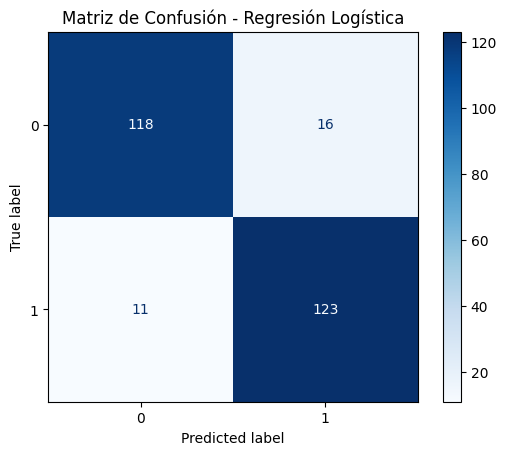

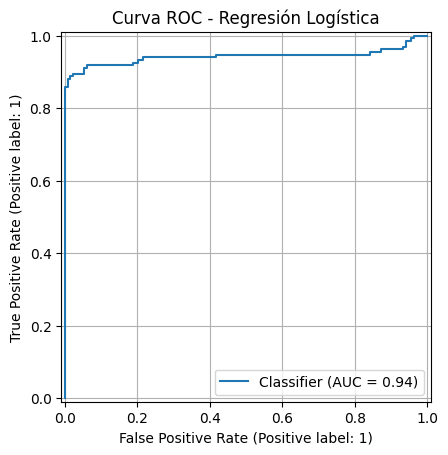


📊 Resultados para Árbol de Decisión:
Accuracy: 0.9328358208955224
Precision: 0.967741935483871
Recall: 0.8955223880597015
F1 Score: 0.9302325581395349
ROC AUC: 0.9330585876587213


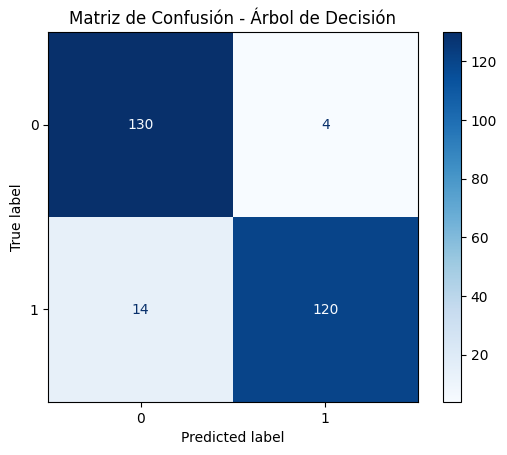

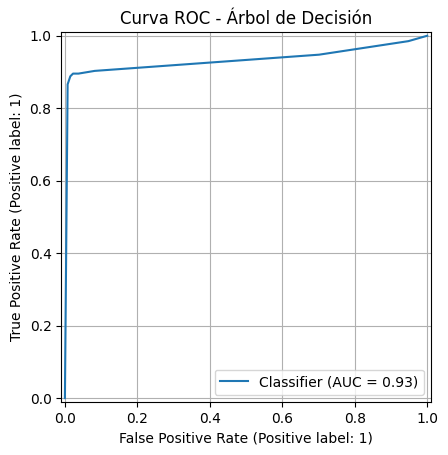

In [21]:
# Evaluar ambos modelos
evaluar_modelo(y_test, y_pred_lr, y_proba_lr, "Regresión Logística")
evaluar_modelo(y_test, y_pred_dt, y_proba_dt, "Árbol de Decisión")

Exploración inicial:

No se encontraron valores nulos.

Se detectaron outliers significativos en las variables bmi y charges, siendo esta última altamente dispersa, lo cual es esperable por la naturaleza de los gastos médicos.

Preprocesamiento:

Se aplicó imputación (mediana para numéricas, moda para categóricas), codificación One-Hot y escalado con StandardScaler.

El preprocesamiento se integró eficientemente en un ColumnTransformer, facilitando su uso en pipelines.

Modelado:

Se entrenaron tres modelos base: Regresión Logística, KNN y Árbol de Decisión, evaluados mediante validación cruzada.

La Regresión Logística mostró un rendimiento competitivo desde el inicio.

Optimización de Hiperparámetros:

Se utilizó GridSearchCV para la Regresión Logística y RandomizedSearchCV para el Árbol de Decisión.

Ambos mejoraron sus métricas tras la optimización, mostrando la importancia de ajustar los modelos correctamente.

Evaluación final:

Se evaluaron los modelos optimizados con métricas completas: Accuracy, Precision, Recall, F1-Score, ROC-AUC.

Se visualizó su rendimiento con matrices de confusión y curvas ROC, mostrando una buena capacidad para distinguir entre clases.


Este proyecto demuestra el ciclo completo de un problema de clasificación: desde la exploración, pasando por el preprocesamiento, hasta la evaluación de modelos con técnicas avanzadas de optimización. Se consolidan buenas prácticas en ciencia de datos y se destaca la importancia de integrar limpieza, modelado y validación en un flujo coherente y reproducible.